In [1]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import theano
import theano.tensor as tt
from theano.tensor import fft
import theano.sparse

# add the gridding path 
import sys
sys.path.append("/home/ian/Research/Disks/MillionPoints/million-points-of-light")
# sys.path.append("/Users/ianczekala/Documents/ALMA/million-points-of-light")

import gridding

# convert from arcseconds to radians
arcsec = np.pi / (180.0 * 3600) # [radians]  = 1/206265 radian/arcsec

In [2]:
def sky_plane(alpha, dec, a=1, delta_alpha=1.0*arcsec, delta_delta=1.0*arcsec, sigma_alpha=1.0*arcsec,
              sigma_delta=1.0*arcsec, Omega=0.0):
    '''
    alpha: ra (in radians)
    delta: dec (in radians)
    a : amplitude
    delta_alpha : offset (in radians)
    delta_dec : offset (in radians)
    sigma_alpha : width (in radians)
    sigma_dec : width (in radians)
    Omega : position angle of ascending node (in degrees east of north)
    '''

    return a * np.exp(-( (alpha - delta_alpha)**2/(2 * sigma_alpha**2) + \
                        (dec - delta_delta)**2/(2 * sigma_delta**2)))


def fourier_plane(u, v, a=1, delta_alpha=1.0*arcsec, delta_delta=1.0*arcsec, sigma_alpha=1.0*arcsec,
              sigma_delta=1.0*arcsec, Omega=0.0):
    '''
    Calculate the Fourier transform of the Gaussian. Assumes u, v in kλ.
    '''

    # convert back to lambda
    u = u * 1e3
    v = v * 1e3

    return 2 * np.pi * a * sigma_alpha * sigma_delta * np.exp(- 2 * np.pi**2 * \
                (sigma_alpha**2 * u**2 + sigma_delta**2 * v**2) - 2 * np.pi * 1.0j * \
                                                    (delta_alpha * u + delta_delta * v))


# the gradients
def dV_ddelta_alpha(u, v, a=1, delta_alpha=1.0*arcsec, delta_delta=1.0*arcsec, sigma_alpha=1.0*arcsec,
              sigma_delta=1.0*arcsec, Omega=0.0):
    
    
    return -2 * np.pi * 1j * u * fourier_plane(u*1e-3, v*1e-3, a, delta_alpha, delta_delta, sigma_alpha,
              sigma_delta, Omega)


def dV_ddelta_delta(u, v, a=1, delta_alpha=1.0*arcsec, delta_delta=1.0*arcsec, sigma_alpha=1.0*arcsec,
              sigma_delta=1.0*arcsec, Omega=0.0):
    
    
    return -2 * np.pi * 1j * v * fourier_plane(u*1e-3, v*1e-3, a, delta_alpha, delta_delta, sigma_alpha,
              sigma_delta, Omega)


In [3]:
def fftspace(width, N):
    '''Oftentimes it is necessary to get a symmetric coordinate array that spans ``N``
     elements from `-width` to `+width`, but makes sure that the middle point lands
     on ``0``. The indices go from ``0`` to ``N -1.``
     `linspace` returns  the end points inclusive, wheras we want to leave out the
     right endpoint, because we are sampling the function in a cyclic manner.'''

    assert N % 2 == 0, "N must be even."

    dx = width * 2.0 / N
    xx = np.empty(N, np.float)
    for i in range(N):
        xx[i] = -width + i * dx
    
    return xx

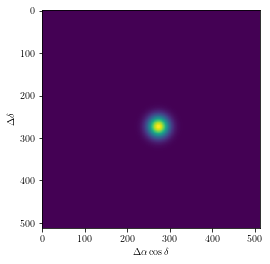

In [4]:
# Let's plot this up and see what it looks like 

N_alpha = 512
N_dec = 512
img_radius = 15.0 * arcsec


# full span of the image
ra = fftspace(img_radius, N_alpha) # [arcsec]
dec = fftspace(img_radius, N_dec) # [arcsec]

# fill out an image 
img = np.empty((N_dec, N_alpha), np.float)

for i,delta in enumerate(dec):
    for j,alpha in enumerate(ra):
        img[i,j] = sky_plane(alpha, delta)

plt.imshow(img, origin="upper", interpolation="none", aspect="equal")
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$\Delta \delta$");

In [6]:
# calculate the maximum u and v points that our image grid can sample 
dRA = (2 * img_radius) / N_alpha # radians
max_baseline = 1 / (2 * dRA) * 1e-3 # kilolambda, nyquist rate
print(max_baseline) # kilolambda

1760.126346641889


In [17]:
# create some fake baselines 
N_vis = np.int(1e5)

u_data = np.random.normal(loc=0, scale=0.1 * max_baseline, size=N_vis)
v_data = np.random.normal(loc=0, scale=0.1 * max_baseline, size=N_vis)

data_points = np.array([u_data, v_data]).T

# calculate the analytical values
data_values = fourier_plane(u_data, v_data)

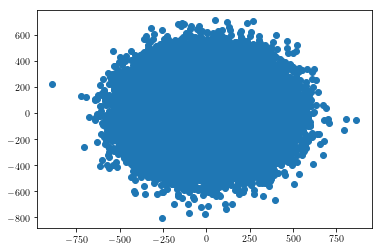

In [8]:
plt.scatter(u_data, v_data)

In [18]:
# fixed quantities that we can pre-calculate before the Theano part 
# create a fixed image plane grid of ras, decs that properly oversamples your beam
# these should already be fftshifted
XX, YY = np.meshgrid(np.fft.fftshift(ra), np.fft.fftshift(dec))

corrfun = gridding.corrfun_mat(np.fft.fftshift(ra), np.fft.fftshift(dec))

# the (N_vis, 2) vector containing the u, v, baselines
# data_points = np.array([[50.0, 10.0], [50.0, 0.0], [50.0, -1.0],
#     [-50.0, 10.0], [5.0, 1.0], [-5.0, 1.0], [5.0, 20.0], [-5.0, -20.0]]) # k lambda
# u_data, v_data = data_points.T
# calculate analytical values
# data_values = fourier_plane(u_data, v_data)

us = np.fft.rfftfreq(N_alpha, d=(2 * img_radius)/N_alpha) * 1e-3  # convert to [kλ]
vs = np.fft.fftfreq(N_dec, d=(2 * img_radius)/N_dec) * 1e-3  # convert to [kλ]

In [19]:
%%time 
# calculate and visualize the C_real and C_imag matrices
# these are scipy csc sparse matrices
C_real, C_imag = gridding.calc_matrices(data_points, us, vs)

CPU times: user 1min 5s, sys: 569 ms, total: 1min 5s
Wall time: 1min 5s


In [20]:
# generate these things with numpy commands that will be made into Theano objects
# 1) calculate the RA and DEC coordinates of the image 

# create input grid
# NOTE that these must be `fftshifted` already.
# add an extra dimension for the later packing into the rfft
alpha = XX[np.newaxis,:]
dalpha = np.abs(alpha[0,0,1] - alpha[0,0,0])
delta = YY[np.newaxis,:]
ddelta = np.abs(delta[0,1,0] - delta[0,0,0])

# 4) calculate the CSC matrix that interpolates the RFFT grid
# Store them as theano shared variables, make sure it's sparse
# TODO: make sure the shape is correct
# C_real_sparse = theano.sparse.CSC(C_real.data, C_real.indices, C_real.indptr, C_real.shape)
# C_imag_sparse = theano.sparse.CSC(C_imag.data, C_imag.indices, C_imag.indptr, C_imag.shape)

# a : amplitude
# delta_alpha : offset (in radians)
# delta_delta : offset (in radians)
# sigma_alpha : width (in radians)
# sigma_delta : width (in radians)

# calculate the sky-plane model
a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
delta_delta = tt.scalar("delta_delta")
sigma_alpha = tt.scalar("sigma_alpha")
sigma_delta = tt.scalar("sigma_delta")

# Calculate the sky-plane model
# since the input coordinates were already shifted, then this is too
I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2) - (delta - delta_delta)**2/(2 * sigma_delta**2))
# I shape should be (1, N_dec, N_alpha)

# taper the image with the gridding correction function
# this should broadcast OK, since the trailing image dimensions match
I_tapered = I * corrfun

# I_func = theano.function([a, delta_alpha, delta_delta, sigma_alpha, sigma_delta], I)

rfft = dalpha * ddelta * fft.rfft(I_tapered, norm=None)
# output from the RFFT is (1, N_delta, N_alpha//2 + 1, 2)

# flatten the RFFT output appopriately, taking the real and imag parts separately
vis_real = rfft[0, :, :, 0].flatten() # real values 
# rshape = tt.shape(vis_real)
# fshape = theano.function([a, delta_alpha, delta_delta, sigma_alpha, sigma_delta], rshape)
vis_imag = rfft[0, :, :, 1].flatten() # imaginary values

# interpolate the RFFT to the baselines
# write a sparse matrix multiply
interp_real = theano.sparse.dot(C_real, vis_real)
interp_imag = theano.sparse.dot(C_imag, vis_imag)

fvis_real = theano.function([a, delta_alpha, delta_delta, sigma_alpha, sigma_delta], interp_real)
fvis_imag = theano.function([a, delta_alpha, delta_delta, sigma_alpha, sigma_delta], interp_imag)

In [21]:
%%time 
out_real = fvis_real(1, 1.0 * arcsec, 1.0 * arcsec, 1.0*arcsec, 1.0*arcsec)
out_imag = fvis_imag(1, 1.0 * arcsec, 1.0 * arcsec, 1.0*arcsec, 1.0*arcsec)

CPU times: user 78.6 ms, sys: 6.53 ms, total: 85.2 ms
Wall time: 84.3 ms


Insert timing code here